In [1]:
import pandas as pd
import numpy as np
path = '../data/'
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
viz_path = '../viz/'
from utils import *
from network import *
from geo_exploration import *

In [2]:
df = load_data(path)
df = preprocess(df)



In [3]:
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,hour_started,minute_started,second_started,year_ended,month_ended,day_ended,weekday_ended,hour_ended,minute_ended,second_ended
295082,11AA3AB3ED9FEFC5,classic_bike,2022-01-01 00:10:20,2022-01-01 00:19:29,Riverview Park,JC057,Riverview Park,JC057,40.744319,-74.043991,...,0,10,20,2022,1,1,5,0,19,29
312873,554FD61E00599BE2,electric_bike,2022-01-01 00:10:24,2022-01-01 00:14:06,Sip Ave,JC056,Glenwood Ave,JC094,40.730897,-74.063913,...,0,10,24,2022,1,1,5,0,14,6
312934,4D3D324F756B7103,electric_bike,2022-01-01 00:10:28,2022-01-01 00:14:12,Sip Ave,JC056,Glenwood Ave,JC094,40.730897,-74.063913,...,0,10,28,2022,1,1,5,0,14,12
295511,E26BB19DBC834216,classic_bike,2022-01-01 00:10:30,2022-01-01 00:24:30,Grove St PATH,JC005,Newport Pkwy,JC008,40.719586,-74.043117,...,0,10,30,2022,1,1,5,0,24,30
298413,DC18B042AA415411,classic_bike,2022-01-01 00:11:31,2022-01-01 00:30:43,Columbus Dr at Exchange Pl,JC106,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,...,0,11,31,2022,1,1,5,0,30,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672735,6596578C32752C21,classic_bike,2023-12-31 23:49:41,2023-12-31 23:55:31,Lafayette Park,JC078,Grove St PATH,JC115,40.713535,-74.062828,...,23,49,41,2023,12,31,6,23,55,31
670769,51DD5B9BEFC08717,classic_bike,2023-12-31 23:49:44,2023-12-31 23:55:33,Lafayette Park,JC078,Grove St PATH,JC115,40.713584,-74.062881,...,23,49,44,2023,12,31,6,23,55,33
697644,8A6FA5AFC2CC7EC8,classic_bike,2023-12-31 23:50:04,2024-01-01 00:28:11,2 St & Park Ave,HB608,4 St & River St,HB611,40.739261,-74.032899,...,23,50,4,2024,1,1,0,0,28,11
695044,E191A2E264EB2890,classic_bike,2023-12-31 23:52:52,2023-12-31 23:55:14,Brunswick St,JC023,Newark Ave,JC032,40.724176,-74.050656,...,23,52,52,2023,12,31,6,23,55,14


In [188]:




def spatial_demand_extraction(df):
    # Create outgoing bikes data
    outgoing = df.groupby(['start_station_name', 'year_started', 'month_started', 'weekday_started', 'hour_started']).size().reset_index(name='outgoing_bikes')

    # Create incoming bikes data
    incoming = df.groupby(['end_station_name', 'year_ended', 'month_ended', 'weekday_ended', 'hour_ended']).size().reset_index(name='incoming_bikes')
 
    outgoing.rename(columns={'start_station_name': 'station_name', 'year_started': 'year', 'month_started': 'month', 'weekday_started': 'weekday', 'hour_started': 'hour'}, inplace=True)
    incoming.rename(columns={'end_station_name': 'station_name', 'year_ended': 'year', 'month_ended': 'month', 'weekday_ended': 'weekday', 'hour_ended': 'hour'}, inplace=True)

    # Merge the dataframes
    demand = pd.merge(outgoing, incoming, how='outer', on=['station_name', 'year', 'month', 'weekday', 'hour'])
    demand.fillna(0, inplace=True)
    demand['net_bikes'] = demand['incoming_bikes'] - demand['outgoing_bikes']
    
    return demand

def temporal_demand_extraction(df):
    demand = df.groupby(['year_started','month_started','weekday_started','hour_started']).size().reset_index(name='count')
    demand = demand.groupby(['year_started','month_started','weekday_started']).agg({'count': 'max'}).reset_index()
    demand.rename(columns={'year_started': 'year', 'month_started': 'month', 'weekday_started': 'weekday', 'hour_started': 'hour'}, inplace=True)
    return demand
    


Results of Dickey-Fuller Test:
Test Statistic                  -2.366309
p-value                          0.151472
#Lags Used                      14.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64


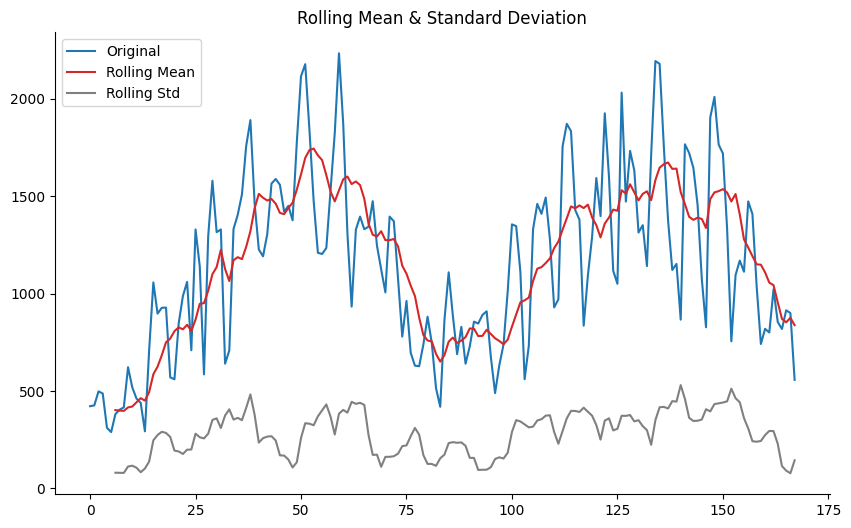

In [189]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

demand = temporal_demand_extraction(df)

# Perform stationarity test
test_stationarity(demand['count'])

# Plotting rolling statistics:
rolmean = demand['count'].rolling(window=7).mean()  # window can be adjusted
rolstd = demand['count'].rolling(window=7).std()

plt.figure(figsize=(10, 6))
plt.plot(demand['count'], color='Tab:blue', label='Original')
plt.plot(rolmean, color='Tab:red', label='Rolling Mean')
plt.plot(rolstd, color='gray', label='Rolling Std')
plt.legend(loc='best')
sns.despine()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

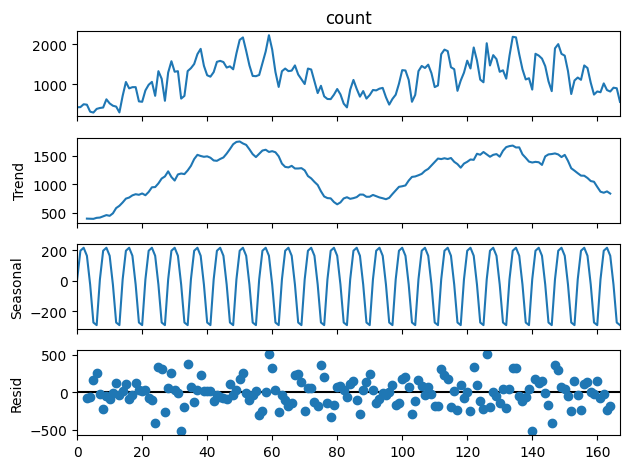

In [166]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(demand['count'], model='additive', period=7)  
result.plot()
plt.show()

In [167]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')

test_stationarity(demand['count'])


ADF Statistic: -2.3663091945058503
p-value: 0.1514719955978236
Critical Value 1%: -3.473829775724492
Critical Value 5%: -2.880622899711496
Critical Value 10%: -2.5769448985432954


In [174]:
# First difference
demand['diff_1'] = demand['count'] - demand['count'].shift(1)

# Seasonal difference
demand['seasonal_diff'] = demand['count'] - demand['count'].shift(84)

# Test stationarity again
test_stationarity(demand['seasonal_diff'].dropna())

ADF Statistic: -5.983465205107656
p-value: 1.8153266219549627e-07
Critical Value 1%: -3.5117123057187376
Critical Value 5%: -2.8970475206326833
Critical Value 10%: -2.5857126912469153


In [176]:
from tbats import TBATS
# Create a TBATS estimator
estimator = TBATS(seasonal_periods=[7, 7*12])

y = demand['count']
# Fit the model
model = estimator.fit(y)

# Summarize model effects
print(model.summary())

# Forecast future values
forecasts = model.forecast(steps=7)  # Forecasting next two days


Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [ 7. 84.]
Seasonal harmonics [ 2 11]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.098964
Seasonal Parameters (Gamma): [-0.0079865   0.00824228 -0.01285068  0.00379812]
AR coefficients []
MA coefficients []
Seed vector [ 9.17456115e+02 -4.92110816e+01  4.56099949e+01  2.59671571e+02
  3.34444541e+01 -4.29338381e+02 -8.19929730e+01 -6.05771721e+00
  1.27884256e+01  3.10092421e+01 -5.81637009e+00  2.60914327e+01
 -2.32259892e+01  4.76144597e+00  3.58790159e+01 -1.22424579e+01
 -1.61128552e+02 -2.27719678e-01 -1.12463575e-01  4.44952431e+01
  1.30450545e+00 -5.62006330e+00  7.66441662e+01 -8.08801440e+01
  1.43092964e+01 -2.04366107e+01 -8.72923294e+01]

AIC 2654.903226


KeyError: 'bike_count'

<Figure size 1400x700 with 0 Axes>

In [181]:
forecasts

array([808.29164233, 950.19386016, 922.68721981, 872.07778149,
       753.22229031, 561.66671384, 571.41572961])

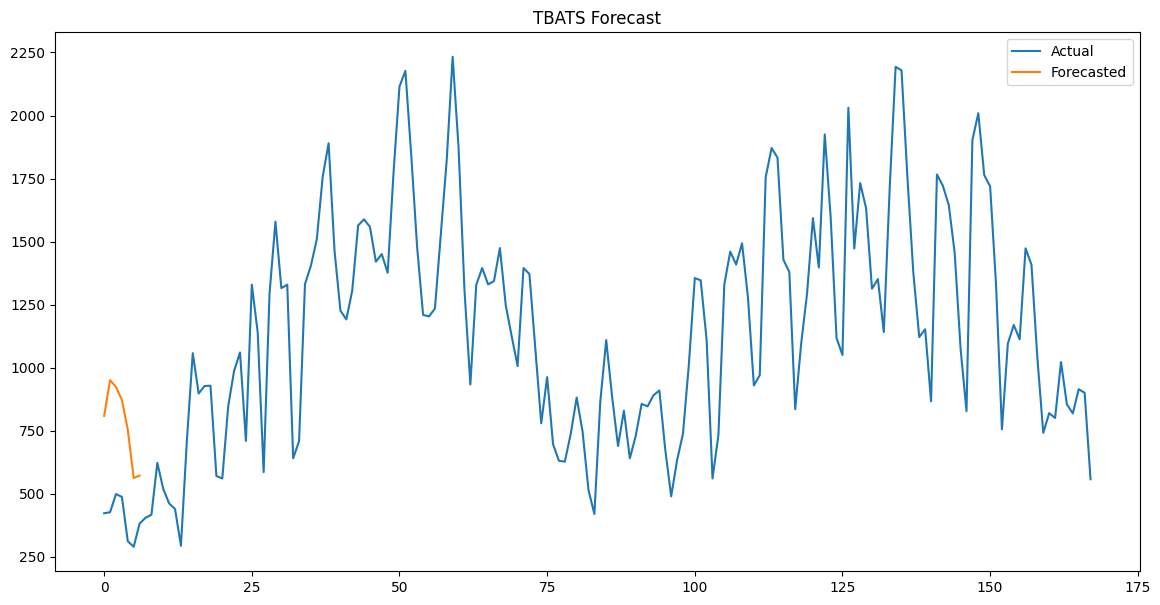

In [182]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(demand.index[-168:], demand['count'].tail(168), label='Actual')
plt.plot(forecasts, label='Forecasted')
plt.title('TBATS Forecast')
plt.legend()
plt.show()

In [121]:
peak_hour.sort_values('net_bikes', ascending=False).head(10)

,year,month,weekday,hour,net_bikes
2611,2023,4,3,19,124.0
836,2022,5,6,20,122.0
861,2022,6,0,21,121.0
1244,2022,8,2,20,118.0
1149,2022,7,5,21,115.0
3595,2023,10,2,19,113.0
2755,2023,5,2,19,112.0
1220,2022,8,1,20,108.0
1316,2022,8,5,20,107.0
2707,2023,5,0,19,106.0


In [92]:
demand.groupby(['year', 'month', 'weekday', 'hour']).agg({'net_bikes': 'sum'}).reset_index()

,year,month,weekday,hour,net_bikes
0,2022,1,0,0,-1.0
1,2022,1,0,1,1.0
2,2022,1,0,2,1.0
3,2022,1,0,3,2.0
4,2022,1,0,4,-1.0
...,...,...,...,...,...
4029,2023,12,6,21,1.0
4030,2023,12,6,22,6.0
4031,2023,12,6,23,-5.0
4032,2024,1,0,0,7.0


In [55]:
cul_demand['max_cumulative_bikes'].min()

-126.0

In [122]:
# Assuming df has columns for bike check-outs and check-ins with timestamps

# Calculate total check-outs per hour across all stations
hourly_demand = df.groupby(['year_started', 'month_started', 'weekday_started', 'hour_started']).size().reset_index(name='Hourly Outgoing')

# Find the maximum hourly demand which represents the peak number of bikes needed at one time
peak_hourly_demand = hourly_demand['Hourly Outgoing'].max()

In [123]:
peak_hourly_demand

2233